In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, rand
import collections
import statsmodels.api as sm

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
df = pd.read_csv("Sample_Madrid.csv")
df

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,El Viso,Entire home/apt,73,5,5,2019-06-16,0.70,1,3,Madrid
1,Universidad,Private room,30,1,26,2019-09-13,9.63,13,228,Madrid
2,Puerta del Angel,Entire home/apt,100,3,20,2019-09-09,3.64,10,89,Madrid
3,Puerta del Angel,Entire home/apt,65,1,8,2019-09-08,2.89,1,167,Madrid
4,Sol,Entire home/apt,180,2,4,2019-06-30,1.03,1,2,Madrid
...,...,...,...,...,...,...,...,...,...,...
4065,Justicia,Shared room,16,1,156,2019-09-02,4.80,8,73,Madrid
4066,Jerónimos,Entire home/apt,90,3,5,2018-11-28,0.11,2,343,Madrid
4067,Palacio,Entire home/apt,70,1,88,2019-09-01,3.07,1,160,Madrid
4068,Palacio,Entire home/apt,110,1,27,2019-09-02,3.06,4,146,Madrid


In [4]:
df = df.drop(columns=['neighbourhood'])
df = df.drop(columns=['city'])
df = df.drop(columns=['last_review'])

In [5]:
df.price=np.log(df.price)

In [6]:
df_apartament = df.loc[df.room_type == "Entire home/apt"]
df_apartament = df_apartament.drop(columns=['room_type'])

In [8]:
df_apartament.shape

(2484, 6)

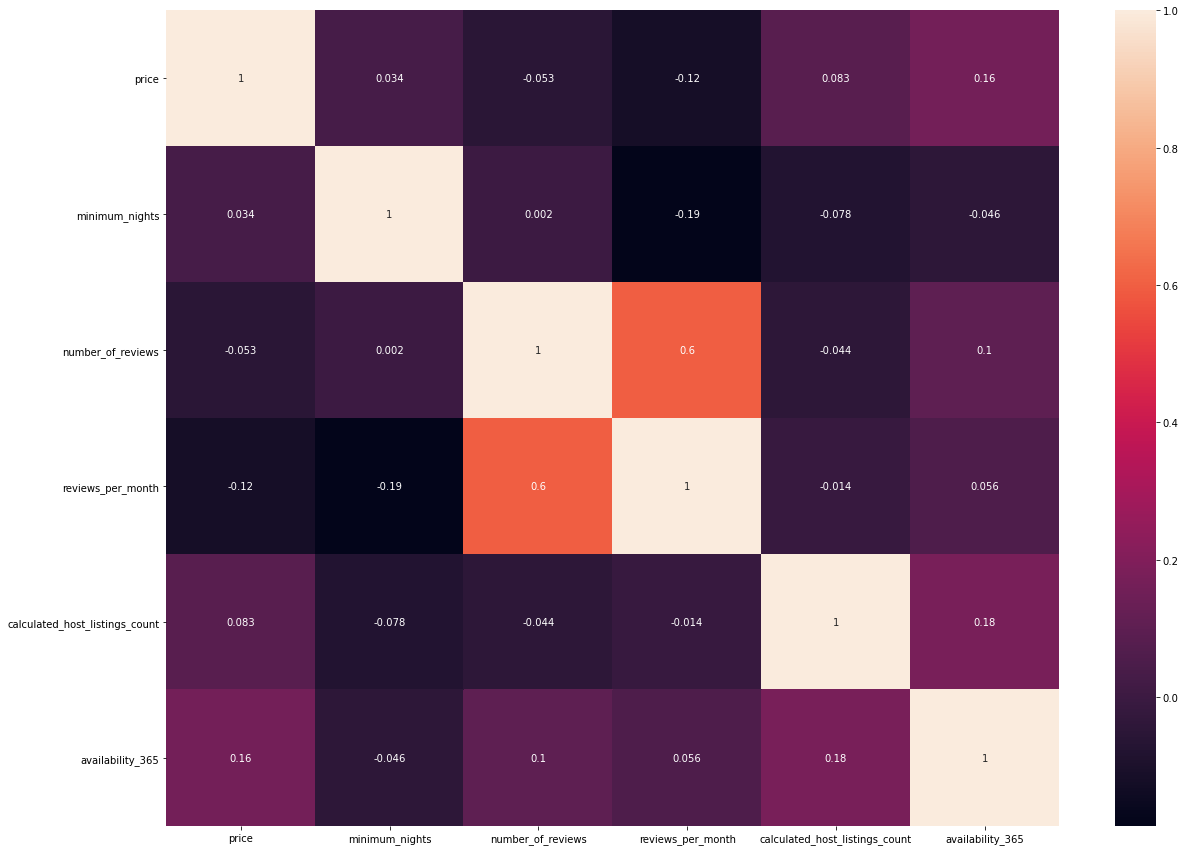

In [9]:
corrmat = df_apartament[df_apartament._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [10]:
#Apartament
train, test = train_test_split(df_apartament, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [11]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    MSE = [mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train))), mean_squared_error(np.exp(y_test), np.exp(y_pred))]
    RMSE = [np.sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train)))),np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'MSE': MSE, 'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

def visualising(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['availability_365']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['availability_365']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Availability 365 (Training set) Madrid')
    plt.xlabel('Availability 365')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['availability_365']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['availability_365']], np.exp(y_pred), 'bo')
    plt.title('Price vs Availability 365 (Test set) Madrid')
    plt.xlabel('Availability 365')
    plt.ylabel('Price')
    plt.show()


In [12]:
mr = LinearRegression().fit(X_train, y_train)
mr.coef_, mr.intercept_

(array([ 0.0045268 ,  0.00012184, -0.02665814,  0.0053671 ,  0.00048905]),
 4.281600845939435)

In [13]:
mr_y_pred = mr.predict(X_test)
metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,1083.98,32.92,0.04
Test,1144.35,33.83,0.06


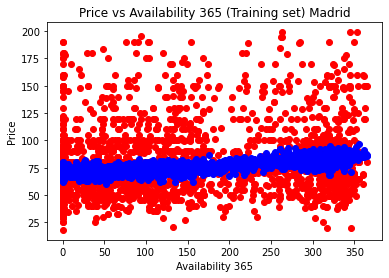

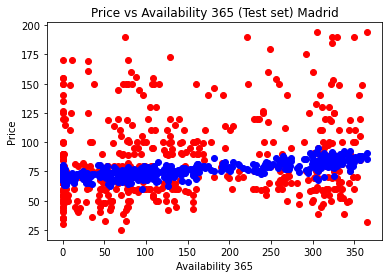

In [14]:
visualising(X_train, X_test, y_train, y_test, mr_y_pred, mr)

In [15]:
X = sm.add_constant(X_train)
mr1 = sm.OLS(y_train, X).fit()
#mr1.pvalues
mr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     16.73
Date:                Tue, 09 Feb 2021   Prob (F-statistic):           3.22e-16
Time:                        21:28:28   Log-Likelihood:                -880.06
No. Observations:                1987   AIC:                             1772.
Df Residuals:                    1981   BIC:                             1806.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              4.2816      0.028    153.074      0.000       4.227       4.336
minimum_nights                     0.0045      0.008      0.555      0.579      -0.011       0.021
number_of_reviews                  0.0001      0.000      0.534      0.593      -0.000       0.001
reviews_per_month                 -0.0267      0.006     -4.182      0.000      -0.039      -0.014
calculated_host_listings_count     0.0054      0.002      2.452      0.014       0.001       0.010
availability_365                   0.0005   7.21e-05      6.778      0.000       0.000       0.001
==============================================================================
Omnibus:                        2.868   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                2.773
Skew:                           0.085   Prob(JB):                        0.250
Kurtosis:                       3.070   Cond. No.                         658.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
X_train_opt = X_train.drop(columns=["number_of_reviews", "minimum_nights"])
X_test_opt = X_test.drop(columns=["number_of_reviews", "minimum_nights"])
X_train_opt

,reviews_per_month,calculated_host_listings_count,availability_365
1968,0.64,11,320
3307,1.24,12,4
657,2.74,2,260
193,2.35,1,100
1528,1.00,1,83
...,...,...,...
1684,3.96,1,0
2809,2.56,1,152
1242,5.26,6,302
1362,0.67,1,363


In [17]:
mr = LinearRegression().fit(X_train_opt, y_train)
mr.coef_, mr.intercept_

(array([-0.02518015,  0.00518353,  0.00049164]), 4.29451885010015)

In [18]:
mr_y_pred = mr.predict(X_test_opt)
metrics(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,1083.76,32.92,0.04
Test,1144.35,33.83,0.05


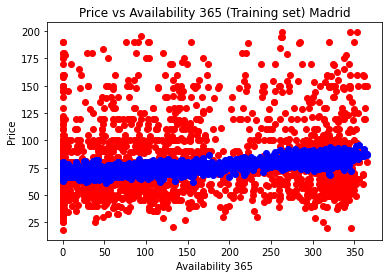

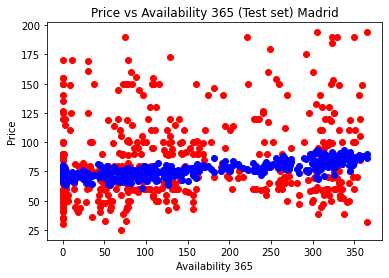

In [19]:
visualising(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr)

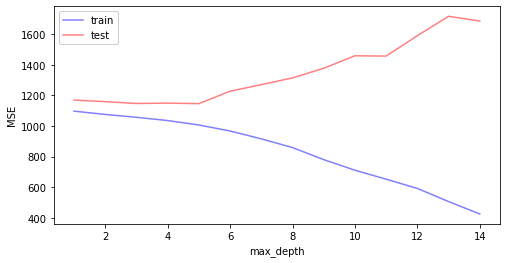

In [20]:
def max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_depth = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [21]:
dt = DecisionTreeRegressor(max_depth = 4, random_state=10).fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2)

,MSE,RMSE,R2
Train,1036.33,32.19,0.09
Test,1150.25,33.92,0.04


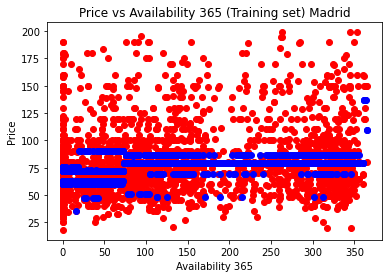

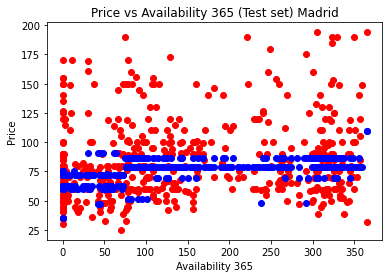

In [22]:
visualising(X_train, X_test, y_train, y_test, dt_y_pred, dt)

Text(0.5, 1.0, 'Decision Tree. Feature Importance. Washington D.C.')

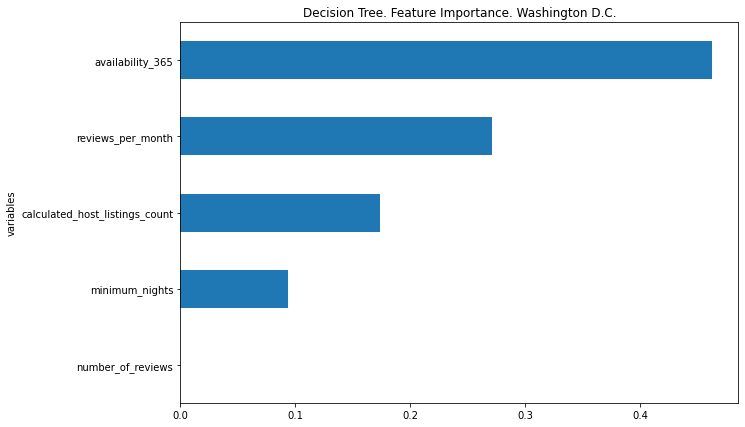

In [23]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'variables': X_train.columns})
dt_imp = dt_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
dt_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Decision Tree. Feature Importance. Washington D.C.')

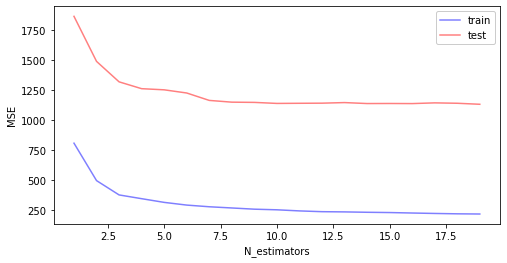

In [24]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
rf_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

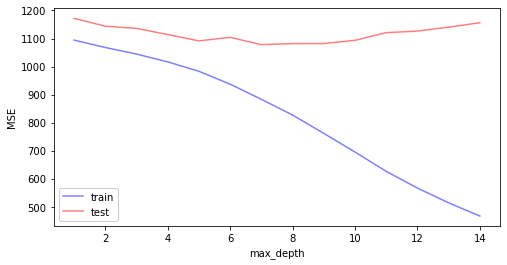

In [25]:
def rf_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=7, max_depth =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
rf_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [26]:
rf = RandomForestRegressor(n_estimators = 7, max_depth = 6, random_state = 10).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2)

,MSE,RMSE,R2
Train,937.29,30.62,0.19
Test,1104.23,33.23,0.08


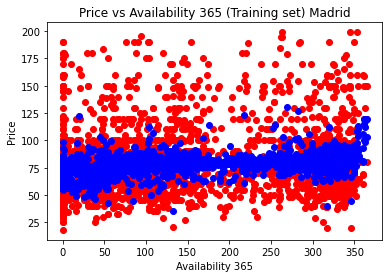

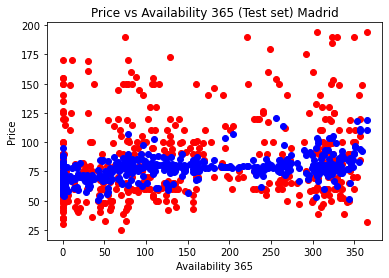

In [27]:
visualising(X_train, X_test, y_train, y_test, rf_y_pred, rf)

<AxesSubplot:ylabel='variables'>

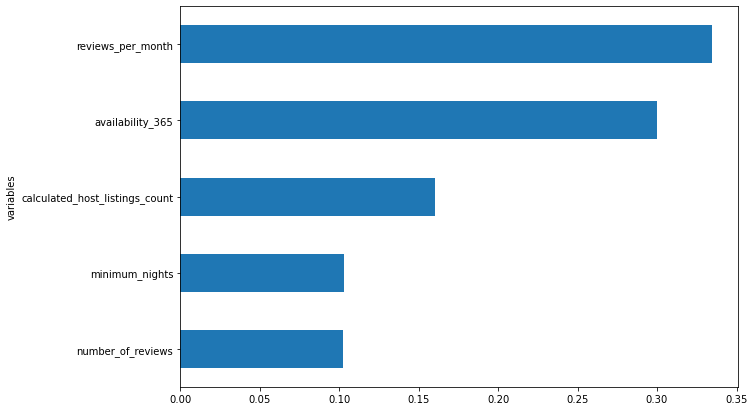

In [28]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'variables': X_train.columns})
rf_imp = rf_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
rf_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
#plt.title('Random Forest. Feature Importance. Washington D.C.')

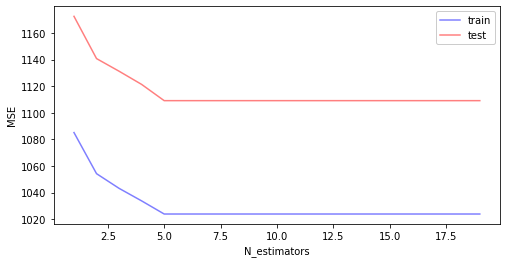

In [29]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

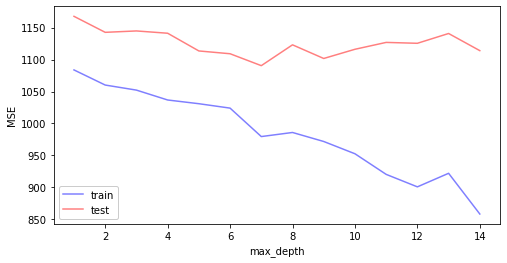

In [30]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=5, max_depth=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [31]:
catboost = CatBoostRegressor(iterations=5, max_depth=7, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
cat_y_pred = catboost.predict(X_test)
metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)

,MSE,RMSE,R2
Train,979.39,31.30,0.14
Test,1090.50,33.02,0.10


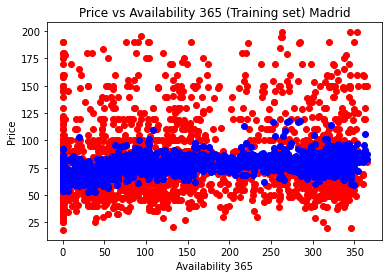

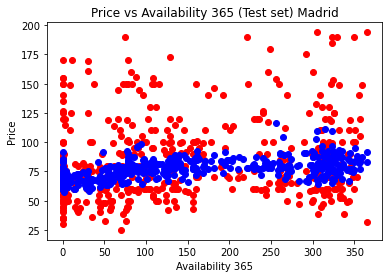

In [32]:
visualising(X_train, X_test, y_train, y_test, cat_y_pred, catboost)

Text(0.5, 1.0, 'Boosting. Feature Importance. Washington D.C.')

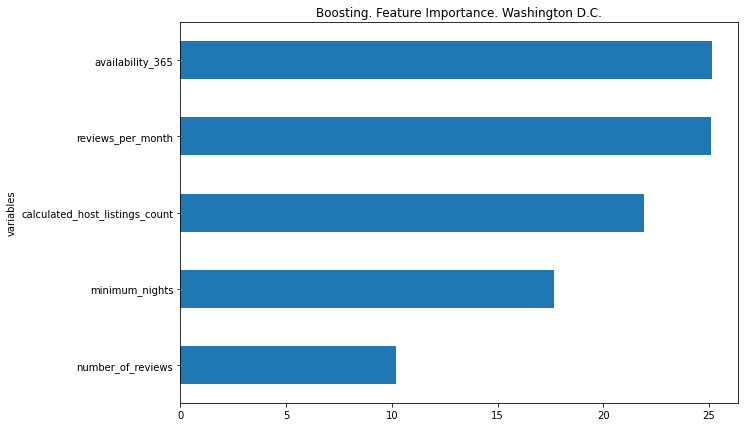

In [33]:
cb_imp = pd.DataFrame({'imp': catboost.get_feature_importance(), 'variables': X_train.columns})
cb_imp = cb_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
cb_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance. Washington D.C.')